In [2]:
import pandas as pd
import psycopg2 
import os
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 10000

In [3]:
conn = psycopg2.connect(
    dbname='cdbsync',
    user='cexplorer',
    host='/tmp/sql-socket',
    port=5432
)




In [4]:
#transaction' size distribution on 2023-03-31

blocks = """
SELECT
    tx.size,
    tx.fee,
    tx.script_size,
    redeemer.unit_mem,
    redeemer.unit_steps
    
FROM block
LEFT JOIN tx ON block.id = tx.block_id  
LEFT JOIN redeemer ON tx.id = redeemer.tx_id
WHERE
  DATE(block.time) in ('2023-03-31')

"""
df = pd.read_sql(blocks,conn)

/tmp/nix-shell.qNMhWM/ipykernel_281466/3676753328.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(blocks,conn)


In [13]:
df_scripts[].corr()

,size,fee,script_size,unit_mem,unit_steps
size,1.000000,0.899811,0.303826,0.026494,0.015482
fee,0.899811,1.000000,-0.068521,-0.018551,0.008436
script_size,0.303826,-0.068521,1.000000,0.348842,0.289063
unit_mem,0.026494,-0.018551,0.348842,1.000000,0.952811
unit_steps,0.015482,0.008436,0.289063,0.952811,1.000000


In [5]:
df['log_size'] = np.log(df['size'])

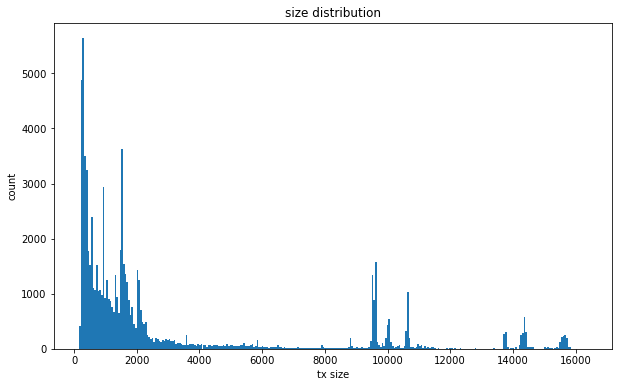

In [7]:
plt.figure(figsize = (10,6))
df['size'].plot(kind='hist',bins=300)
plt.title('size distribution')
plt.xlabel('tx size')
plt.ylabel('count')
plt.savefig("../docs/imgs/31_03_2023_size_distribution.png", dpi=300)
plt.show()


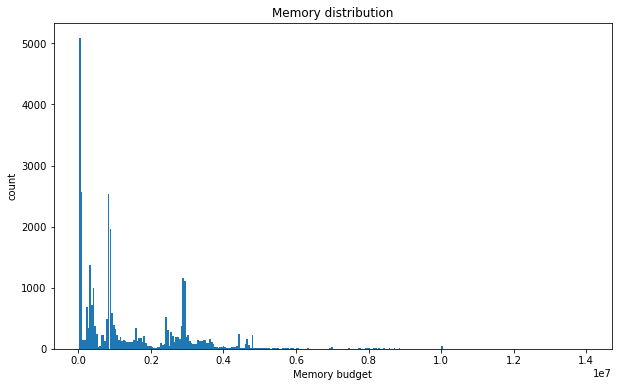

In [13]:
plt.figure(figsize = (10,6))
df['unit_mem'].plot(kind='hist',bins=300)
plt.title('Memory distribution')
plt.xlabel('Memory budget')
plt.ylabel('count')
plt.savefig("../docs/imgs/31_03_2023_mem_distribution.png", dpi=300)
plt.show()


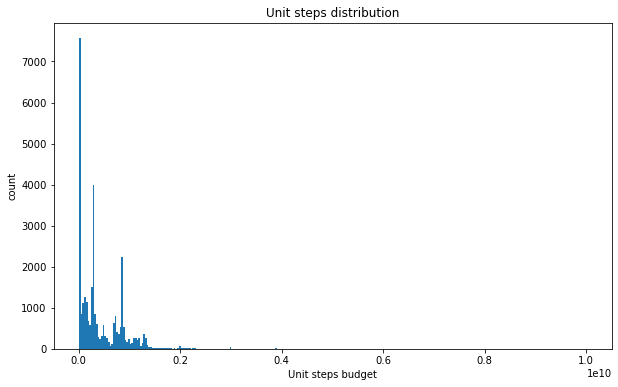

In [48]:
plt.figure(figsize = (10,6))
df['unit_steps'].plot(kind='hist',bins=300)
plt.title('Unit steps distribution')
plt.xlabel('Unit steps budget')
plt.ylabel('count')
plt.savefig("../docs/imgs/31_03_2023_cpu_distribution.png", dpi=300)
plt.show()


In [11]:
# Define bins
bins = [0, 100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 
        5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
       ]
labels = [0, 100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 
        5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000
       ]



# Create binned column
df['bin'] = pd.cut(df['size'], bins=bins, labels=labels, right=False)

# Create frequency table based on bins
freq_table = df['bin'].value_counts().reset_index().rename(columns={'index': 'Interval/Class', 'bin': 'Frequency'}).sort_values(by='Interval/Class')
freq_table['Relative Frequency'] = freq_table['Frequency'] / freq_table['Frequency'].sum()
freq_table['Cumulative Frequency'] = freq_table['Frequency'].cumsum()
markdown_table = tabulate(freq_table, headers='keys', tablefmt='pipe', showindex=False)

print(markdown_table)


|   Interval/Class |   Frequency |   Relative Frequency |   Cumulative Frequency |
|-----------------:|------------:|---------------------:|-----------------------:|
|                0 |           0 |          0           |                      0 |
|              100 |         345 |          0.00439726  |                    345 |
|              200 |       15844 |          0.201942    |                  16189 |
|              400 |        7487 |          0.0954269   |                  23676 |
|              600 |        4240 |          0.0540417   |                  27916 |
|              800 |        5693 |          0.0725611   |                  33609 |
|             1000 |       20404 |          0.260063    |                  54013 |
|             2000 |        6900 |          0.0879451   |                  60913 |
|             3000 |        2004 |          0.0255423   |                  62917 |
|             4000 |        1189 |          0.0151546   |                  64106 |
|   

In [41]:
# Define bins
bins = [0,10000] + [i*1e5 for i in range(1,10)] + [i*1e6 for i in range(1,15)]
labels = bins[:-1]



# Create binned column
df['bin'] = pd.cut(df['unit_mem'].fillna(0), bins=bins, labels=labels, right=False)

# Create frequency table based on bins
freq_table = df['bin'].value_counts().reset_index().rename(columns={'index': 'Interval/Class', 'bin': 'Frequency'}).sort_values(by='Interval/Class')
freq_table['Relative Frequency'] = freq_table['Frequency'] / freq_table['Frequency'].sum()
freq_table['Cumulative Frequency'] = freq_table['Frequency'].cumsum()
markdown_table = tabulate(freq_table, headers='keys', tablefmt='pipe', showindex=False)

print(markdown_table)


|   Interval/Class |   Frequency |   Relative Frequency |   Cumulative Frequency |
|-----------------:|------------:|---------------------:|-----------------------:|
|          0       |       47241 |          0.600664    |                  47241 |
|      10000       |        6543 |          0.0831935   |                  53784 |
|     100000       |        1381 |          0.0175593   |                  55165 |
|     200000       |        1038 |          0.013198    |                  56203 |
|     300000       |        2193 |          0.0278837   |                  58396 |
|     400000       |        1301 |          0.0165421   |                  59697 |
|     500000       |         241 |          0.00306429  |                  59938 |
|     600000       |         406 |          0.00516224  |                  60344 |
|     700000       |         311 |          0.00395433  |                  60655 |
|     800000       |        4852 |          0.0616926   |                  65507 |
|   

In [54]:
# Define bins
bins = [0] + [i*1e8 for i in range(1,10)] + [i*1e9 for i in range(1,12)]
labels = bins[:-1]



# Create binned column
df['bin'] = pd.cut(df['unit_steps'].fillna(0), bins=bins, labels=labels, right=False)

# Create frequency table based on bins
freq_table = df['bin'].value_counts().reset_index().rename(columns={'index': 'Interval/Class', 'bin': 'Frequency'}).sort_values(by='Interval/Class')
freq_table['Relative Frequency'] = freq_table['Frequency'] / freq_table['Frequency'].sum()
freq_table['Cumulative Frequency'] = freq_table['Frequency'].cumsum()
markdown_table = tabulate(freq_table, headers='keys', tablefmt='pipe', showindex=False)

print(markdown_table)


|   Interval/Class |   Frequency |   Relative Frequency |   Cumulative Frequency |
|-----------------:|------------:|---------------------:|-----------------------:|
|            0     |       56668 |          0.720499    |                  56668 |
|            1e+08 |        2953 |          0.0375456   |                  59621 |
|            2e+08 |        6015 |          0.0764771   |                  65636 |
|            3e+08 |        1983 |          0.0252126   |                  67619 |
|            4e+08 |        1046 |          0.0132993   |                  68665 |
|            5e+08 |         851 |          0.01082     |                  69516 |
|            6e+08 |         762 |          0.00968837  |                  70278 |
|            7e+08 |        1555 |          0.0197709   |                  71833 |
|            8e+08 |        3329 |          0.0423262   |                  75162 |
|            9e+08 |         563 |          0.00715821  |                  75725 |
|   

In [5]:
# only scripts
df_scripts = df[df.script_size>0]


In [12]:
import pandas as pd
from sklearn.cluster import KMeans


df = df_scripts[['script_size', 'unit_mem', 'unit_steps']]


# Number of clusters
num_clusters = 10


kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(df)
df['cluster'] = kmeans.labels_


group_means = df.groupby('cluster').mean()


group_counts = df.groupby('cluster').size()


result = group_means
result['count'] = group_counts

print(result.sort_values(by=['script_size']))


          script_size      unit_mem    unit_steps  count
cluster                                                 
5         2173.000000  1.400000e+07  1.000000e+10      3
4         3238.625781  4.243623e+05  1.614216e+08   3359
8         3483.842105  6.872848e+06  3.005361e+09     38
2         4674.379310  9.862069e+06  3.903448e+09     29
6         5590.389474  4.298808e+06  1.972200e+09     95
9         5755.905248  1.532300e+06  4.593735e+08    686
0         6311.813234  1.110107e+05  3.367477e+07   5622
3         8205.285928  2.813822e+06  8.364440e+08   2679
1         8466.241379  3.688543e+06  1.104721e+09    609
7        10833.265905  4.425865e+06  1.330972e+09    613


/nix/store/c0cl81klxhkab63fxlprr28k343hjrwa-python3.10-scikit-learn-1.2.1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/nix-shell.qNMhWM/ipykernel_281466/293703297.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_
